## Example

d:\work\computer-vision-experiments\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.14 (you have 1.4.13). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


Using only 10 images out of 5000
Data type: DataType.TRAIN, Number of images: 8
Using only 10 images out of 5000
Data type: DataType.VALIDATION, Number of images: 2


Val Epoch 0: 100%|██████████| 1/1 [00:00<00:00, 14.92it/s, val_loss=0.118]

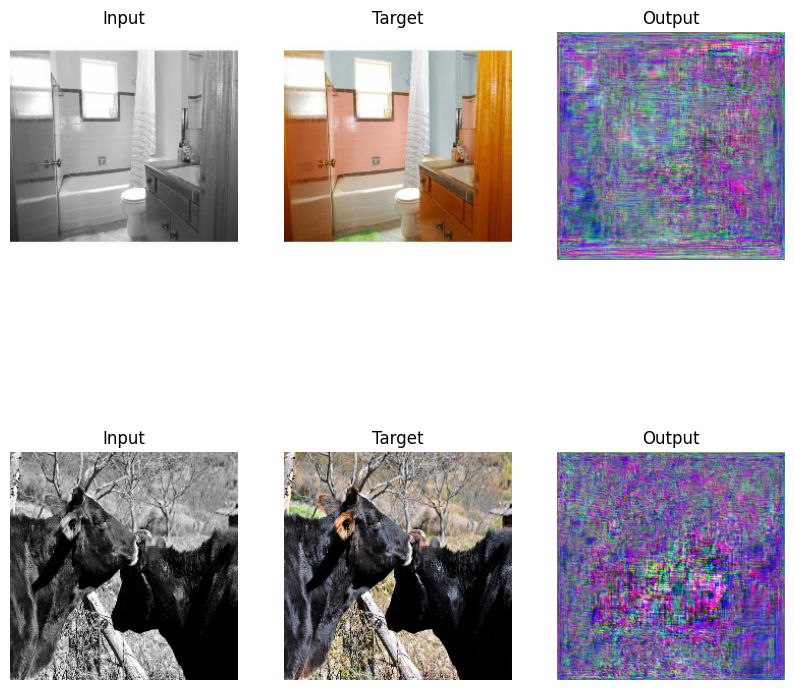

Val Epoch 0: 100%|██████████| 1/1 [00:00<00:00,  1.62it/s, val_loss=0.118]


[08/19/24 18:47:45] INFO     2024-08-19 18:47:45,421 - CVExpt - INFO - Step: 0, train_loss:       ]8;id=925507;file://d:\work\computer-vision-experiments\cv_expt\base\logger\base_logger.py\base_logger.py]8;;\:]8;id=716919;file://d:\work\computer-vision-experiments\cv_expt\base\logger\base_logger.py#63\63]8;;\
                             0.12630721926689148                                                                   

                    INFO     2024-08-19 18:47:45,522 - CVExpt - INFO - Step: 0, val_loss:         ]8;id=406376;file://d:\work\computer-vision-experiments\cv_expt\base\logger\base_logger.py\base_logger.py]8;;\:]8;id=567379;file://d:\work\computer-vision-experiments\cv_expt\base\logger\base_logger.py#63\63]8;;\
                             0.11810903251171112                                                                   

                    INFO     2024-08-19 18:47:45,771 - CVExpt - INFO - Best model saved at      ]8;id=603425;file://d:\work\computer-vision-experiments\cv_expt\base\trainer\base_trainer.py\base_trainer.py]8;;\:]8;id=812991;file://d:\work\computer-vision-experiments\cv_expt\base\trainer\base_trainer.py#185\185]8;;\
                             results\expt1\run_2024-08-19\best_model.pth                                           

                    INFO     2024-08-19 18:47:45,775 - CVExpt - INFO - Epoch 0 completed        ]8;id=629855;file://d:\work\computer-vision-experiments\cv_expt\base\trainer\base_trainer.py\base_trainer.py]8;;\:]8;id=606507;file://d:\work\computer-vision-experiments\cv_expt\base\trainer\base_trainer.py#108\108]8;;\

Val Epoch 1: 100%|██████████| 1/1 [00:00<00:00, 49.22it/s, val_loss=0.0985]

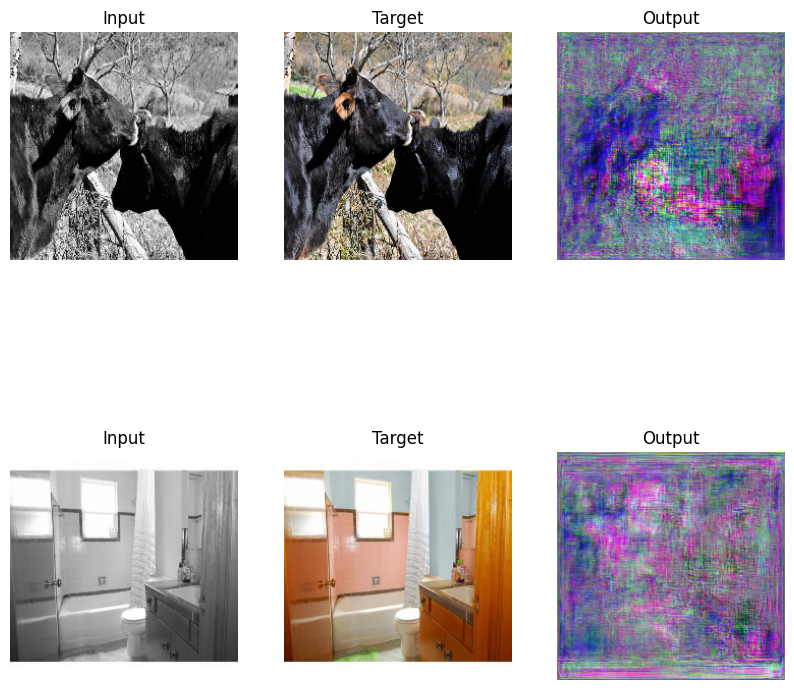

Val Epoch 1: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s, val_loss=0.0985]


[08/19/24 18:47:46] INFO     2024-08-19 18:47:46,605 - CVExpt - INFO - Step: 1, train_loss:       ]8;id=576797;file://d:\work\computer-vision-experiments\cv_expt\base\logger\base_logger.py\base_logger.py]8;;\:]8;id=355061;file://d:\work\computer-vision-experiments\cv_expt\base\logger\base_logger.py#63\63]8;;\
                             0.0923595055937767                                                                    

                    INFO     2024-08-19 18:47:46,708 - CVExpt - INFO - Step: 1, val_loss:         ]8;id=575647;file://d:\work\computer-vision-experiments\cv_expt\base\logger\base_logger.py\base_logger.py]8;;\:]8;id=606663;file://d:\work\computer-vision-experiments\cv_expt\base\logger\base_logger.py#63\63]8;;\
                             0.09848209470510483                                                                   

                    INFO     2024-08-19 18:47:46,922 - CVExpt - INFO - Best model saved at      ]8;id=384502;file://d:\work\computer-vision-experiments\cv_expt\base\trainer\base_trainer.py\base_trainer.py]8;;\:]8;id=692928;file://d:\work\computer-vision-experiments\cv_expt\base\trainer\base_trainer.py#185\185]8;;\
                             results\expt1\run_2024-08-19\best_model.pth                                           

                    INFO     2024-08-19 18:47:46,922 - CVExpt - INFO - Epoch 1 completed        ]8;id=849353;file://d:\work\computer-vision-experiments\cv_expt\base\trainer\base_trainer.py\base_trainer.py]8;;\:]8;id=760587;file://d:\work\computer-vision-experiments\cv_expt\base\trainer\base_trainer.py#108\108]8;;\

Val Epoch 2: 100%|██████████| 1/1 [00:00<00:00, 34.36it/s, val_loss=0.0788]

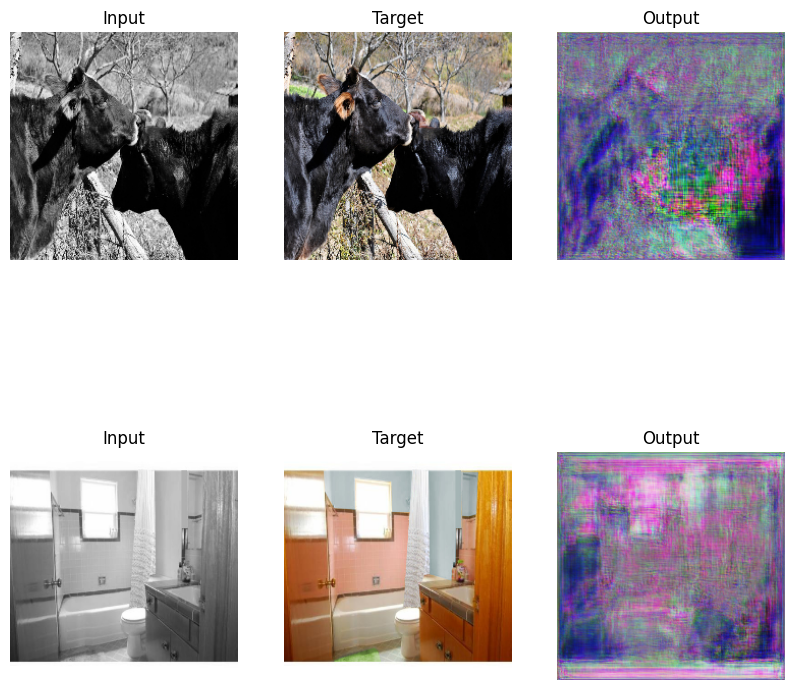

Val Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s, val_loss=0.0788]


[08/19/24 18:47:47] INFO     2024-08-19 18:47:47,726 - CVExpt - INFO - Step: 2, train_loss:       ]8;id=990007;file://d:\work\computer-vision-experiments\cv_expt\base\logger\base_logger.py\base_logger.py]8;;\:]8;id=948891;file://d:\work\computer-vision-experiments\cv_expt\base\logger\base_logger.py#63\63]8;;\
                             0.06868522614240646                                                                   

                    INFO     2024-08-19 18:47:47,855 - CVExpt - INFO - Step: 2, val_loss:         ]8;id=913895;file://d:\work\computer-vision-experiments\cv_expt\base\logger\base_logger.py\base_logger.py]8;;\:]8;id=277179;file://d:\work\computer-vision-experiments\cv_expt\base\logger\base_logger.py#63\63]8;;\
                             0.07878714054822922                                                                   

[08/19/24 18:47:48] INFO     2024-08-19 18:47:48,275 - CVExpt - INFO - Best model saved at      ]8;id=173063;file://d:\work\computer-vision-experiments\cv_expt\base\trainer\base_trainer.py\base_trainer.py]8;;\:]8;id=153709;file://d:\work\computer-vision-experiments\cv_expt\base\trainer\base_trainer.py#185\185]8;;\
                             results\expt1\run_2024-08-19\best_model.pth                                           

                    INFO     2024-08-19 18:47:48,278 - CVExpt - INFO - Epoch 2 completed        ]8;id=389581;file://d:\work\computer-vision-experiments\cv_expt\base\trainer\base_trainer.py\base_trainer.py]8;;\:]8;id=178739;file://d:\work\computer-vision-experiments\cv_expt\base\trainer\base_trainer.py#108\108]8;;\

In [1]:
from cv_expt.base.data.base_dataset import ImageDataset, ImageDataType
from cv_expt.base.defs.defs import ImageChannel, DataType
from cv_expt.base.logger.base_logger import BaseLogger, BaseLoggerConfig
from cv_expt.base.configs.configs import TrainerConfig, DataConfig
from cv_expt.vis.visualization import subplot_images
from cv_expt.base.logger.base_logger import BaseLogger
from cv_expt.base.models.base_model import ModelWrapper
from cv_expt.base.trainer.base_trainer import Trainer

from pathlib import Path
from typing import Optional
import torch
import cv2
import numpy as np
from tqdm import tqdm  # for progress bar
from torch import nn
from torch.optim import Optimizer
import segmentation_models_pytorch as smp
import datetime

data_config = DataConfig(
    data_path=Path("../assets/training_data/val2017"),
    image_channels=ImageChannel.RGB,
    image_extensions=["jpg", "png"],
    max_data=10,
)
train_dataset = ImageDataset(
    data_config,
    return_type=ImageDataType.TENSOR,
    normalization=lambda x: x / 255.0,
    denormalization=lambda x: (x * 255.0),
)
val_dataset = ImageDataset(
    data_config,
    data_type=DataType.VALIDATION,
    return_type=ImageDataType.TENSOR,
    normalization=lambda x: x / 255.0,
    denormalization=lambda x: (x * 255.0),
)

config = TrainerConfig(
    result_dir=Path("results"),
    expt_name="expt1",
    run_name=f"run_{datetime.datetime.now().date()}",
    epochs=3,
    show_images=True,
)
model = smp.Unet("resnet18", classes=3, in_channels=1, activation="sigmoid")
model = ModelWrapper(
    model,
    postprocess=val_dataset.denormalization,
    preprocess=val_dataset.normalization,
)

optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()
trainer = Trainer(
    model,
    config,
    optimizer,
    criterion,
    BaseLogger(BaseLoggerConfig(log_path=config.result_dir)),
    train_dataset,
    val_dataset,
)
trainer.train()

## Inference of Some Unseen Images